In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, HBox, VBox, Label
from smt.sampling_methods import LHS
from multiprocess import Pool
from scipy.signal import argrelmin, argrelmax


In [2]:
# I use this library because it includes both implicit and explicit integrators 
# and advanced tools for bifurcation analysis, etc. 
import PyDSTool as dst

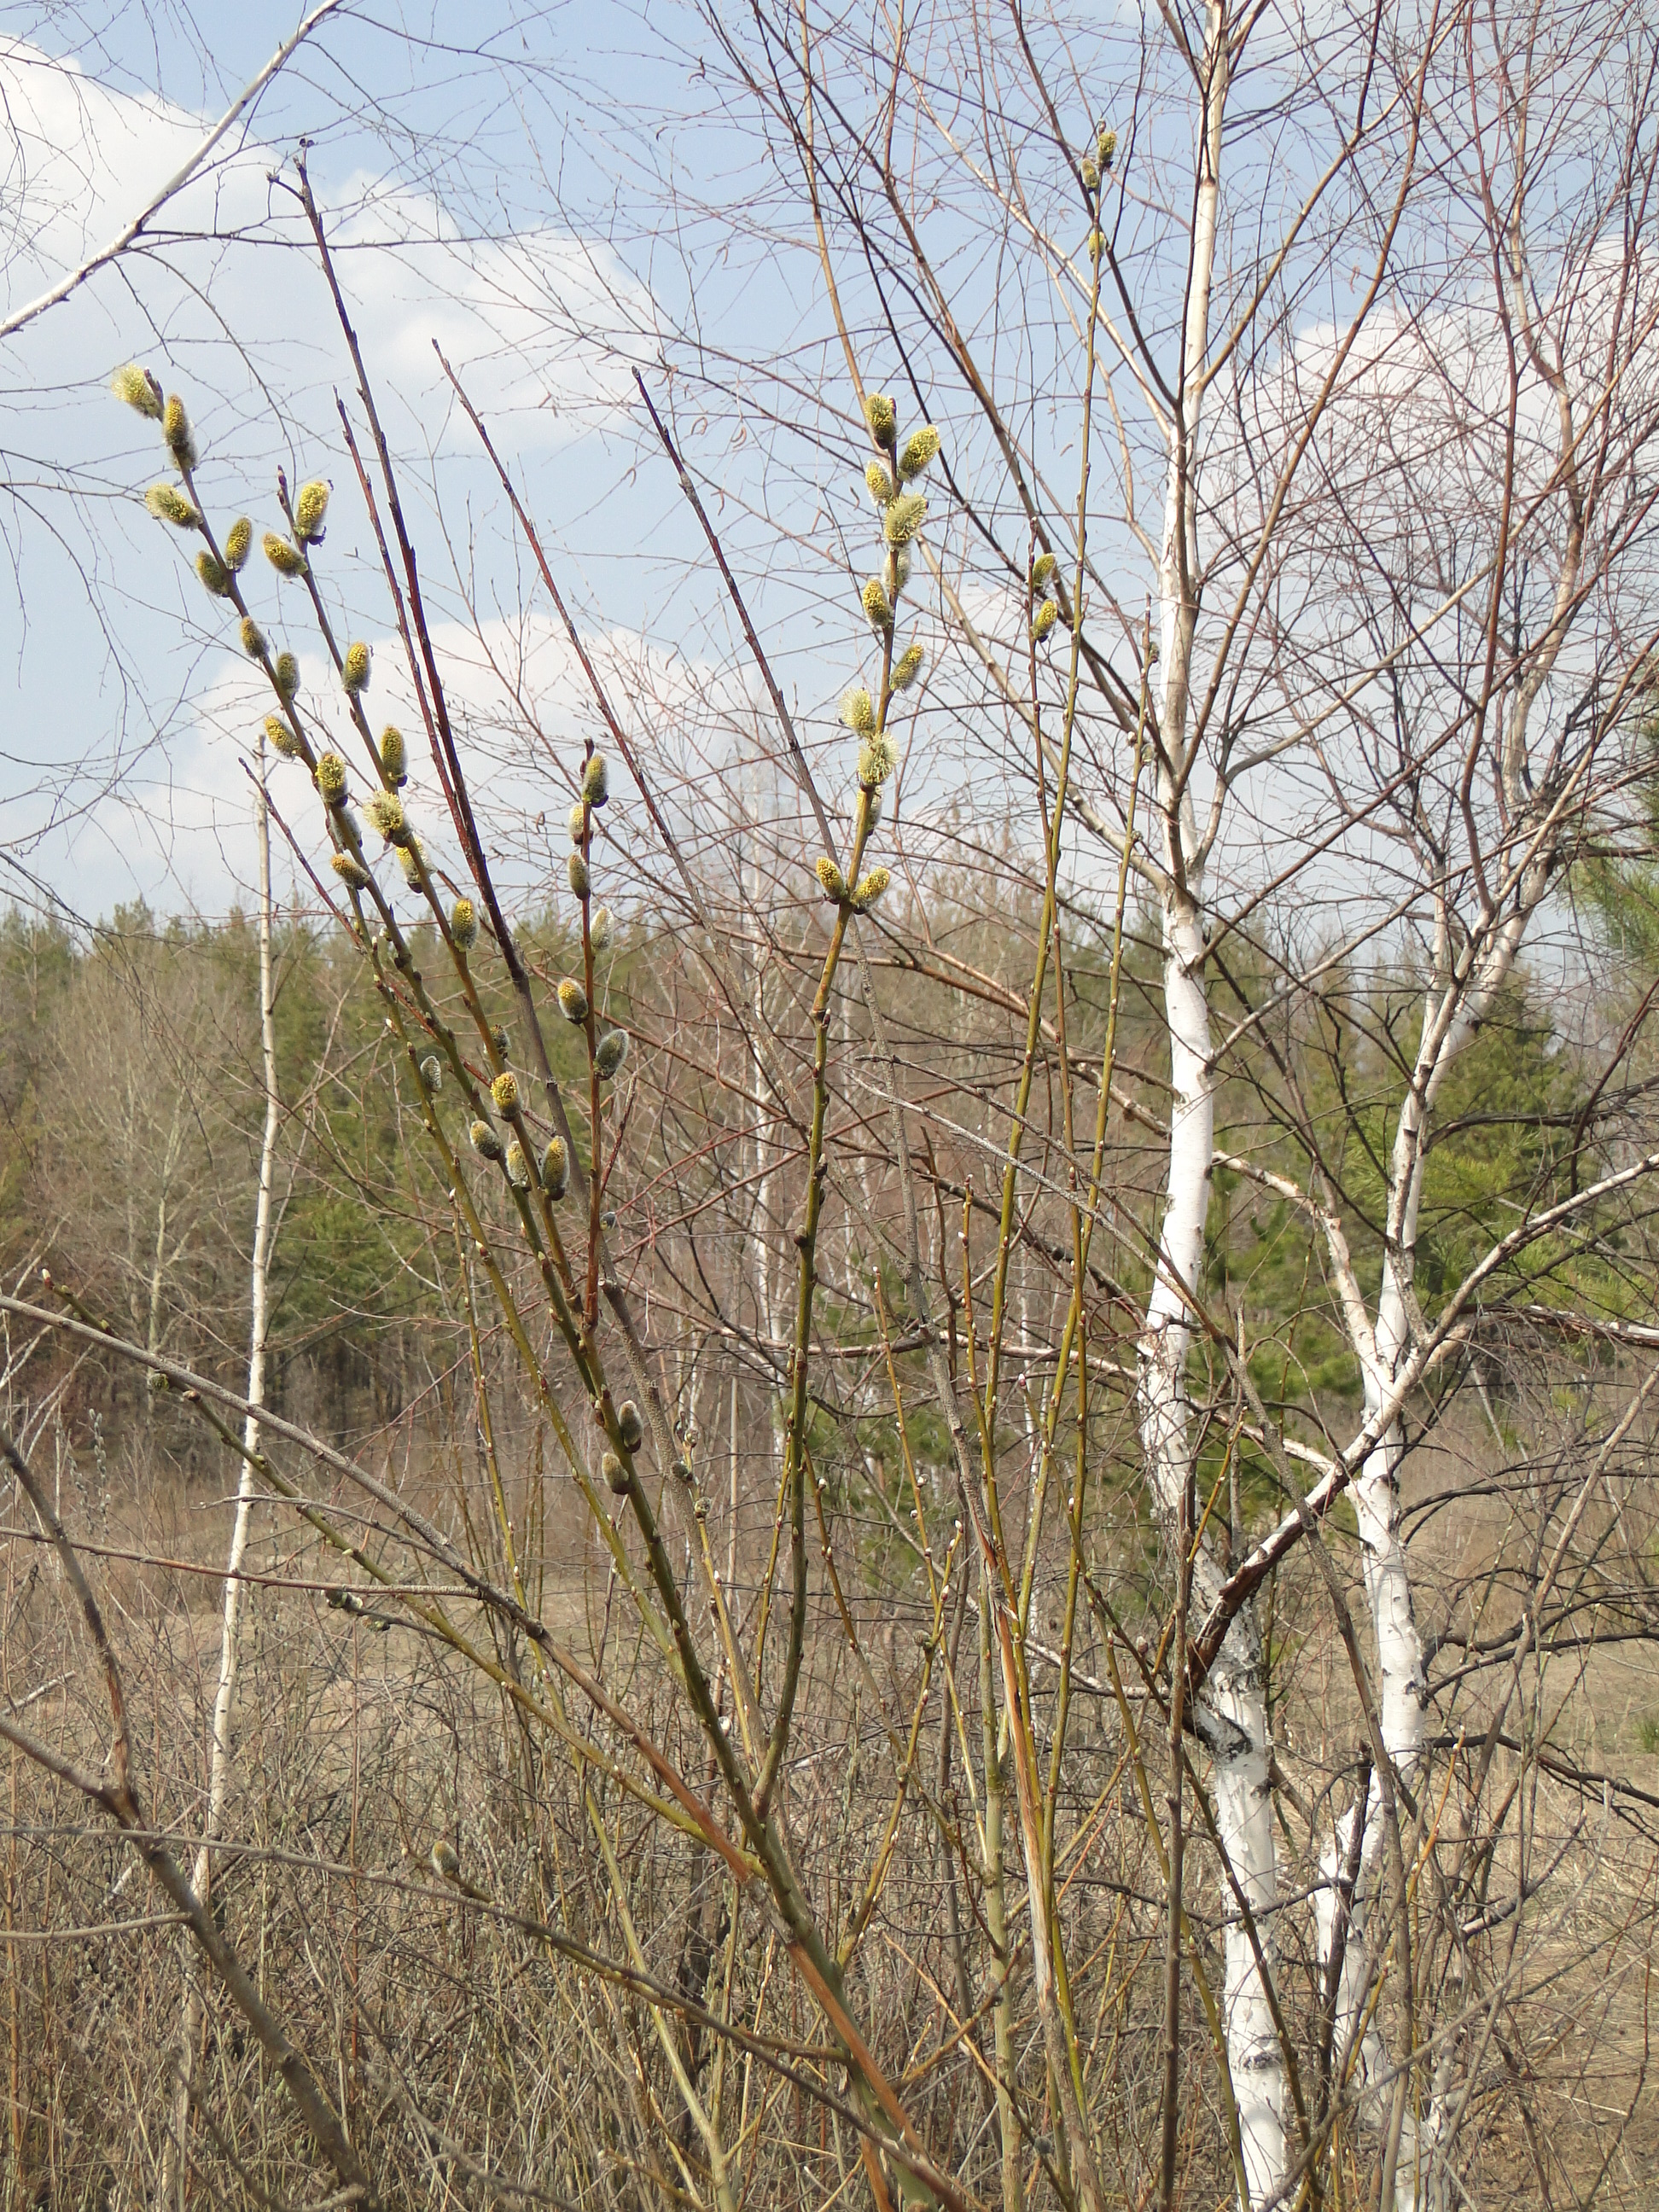

In [3]:
DSargs = dst.args(name='Fedor2021')

In [4]:
def enzymeConcentration(n):
    return n/(6.03*10**(23))*(10**20)

In [9]:
enzymeConcentration(640)

0.10613598673300166

In [17]:
# Things to do:
# Add TRPC
# Add NCX
# Add ORAI
# Get rid of B
# Play with parameters to get appropriate time scales
# Add shape-fitting tool
# Plan meta-analysis
# ???
# PROFIT!

# NCX turnover ~ 1000
# NCX KD ~ 1 uM
# NCX CN = 580
# PMCA turnover ~ 100
# PMCA KD ~ .1 uM
# PMCA CN = 640

a2 = 0.6
a5 = 400

myPars = { 'a2': a2, #"on" rate constant for IP3R inhibiting site
                'a5': a5, #"on" rate constant for IP3R activating site
               'p': .3, # IP3 concentration
               'v0': 0.001, #Leak through ER membrane 
               'v1': .5, #IP3R Vmax
               'v3': 15., #SERCA2B Vmax
               'v4': 27., #SERCA3A Vmax
               'k3': 0.26, #SERCA2B K05
               'k4': 1.1, #SERCA3A K05
               'A': 4., #IP3R cooperativity constant
               'B': 1.5, #Magic fitting constant for IP3R "clustering" - to be removed
               'c0': 10., # Total calcium concentration with respect to cytosol - to be removed
               'c1': 0.05, #ER-cytosol volume ratio
               'kBuff': 1., #EF-hand buffering agent binding constant
               'Buff':10., #EF-hand buffering agent concentration
               'kBuff2': 1.2, #Calcium dye binding constant
               'Buff2':2., #Calcium dye concentration
               'passiveFluxCyt': 0.01,
                 'TRPCrate': 0.07,
             'PMCArate': .1,
             'PMCAKm': 0.3,
             'NCXrate': 10,
             'NCXKm': .8}

myStrings = {   'a2': "\"on\" rate constant for IP3R inhibiting site",
                'a5': "\"on\" rate constant for IP3R activating site",
                'p': "IP3 concentration",
                'v0': "Leak through ER membrane ",
                'v1': "IP3R Vmax",
                'v3': "SERCA2B Vmax",
                'v4': "SERCA3A Vmax",
                'k3': "SERCA2B K05",
                'k4': "SERCA3A K05",
                'A': "IP3R cooperativity constant",
                'B': "Magic fitting constant for IP3R \"clustering\" - to be removed",
                'c0': " Total calcium concentration with respect to cytosol - to be removed",
                'c1': "ER-cytosol volume ratio",
                'kBuff': "EF-hand buffering agent binding constant",
                'Buff': "EF-hand buffering agent concentration",
                'kBuff2': "Calcium dye binding constant",
                'Buff2': "Calcium dye concentration"
              }

DSargs.pars = myPars
#Auxiliary functions
DSargs.fnspecs  = {'Jin': (['pp'], 'passiveFluxCyt + TRPCrate*pp'), #Flux inside cytosol through cellular membrane: 
#                    a passive one and dummy function for TRPC as a function of IP3 
                   'Jpm': (['c'], 'PMCArate*c*c/(PMCAKm*PMCAKm + c*c) + NCXrate*c*c/(NCXKm*NCXKm + c*c)')} #PMCA pump in Hill approximation 
#                    and a placeholder for NCX and ORAI

In [18]:
# Here I build intervals to be used in latin Hypercube
myLims = np.array([[0.5*myPars[p],2*myPars[p]] for p in myPars])

In [19]:
dummyList = list(myPars.values())

In [20]:
# Constructor of LHSampling
sampling = LHS(xlimits=myLims)
# Number of samples
num = 500
# Actual samples
x = sampling(num)
# np.save('sampling',x)

In [21]:
x

array([[8.9130e-01, 3.0500e+02, 4.9785e-01, ..., 3.4845e-01, 5.1350e+00,
        7.1320e-01],
       [3.7650e-01, 5.1500e+02, 3.7365e-01, ..., 2.0355e-01, 1.4945e+01,
        1.5340e+00],
       [4.4130e-01, 5.6780e+02, 4.0515e-01, ..., 4.7265e-01, 1.1915e+01,
        1.2124e+00],
       ...,
       [6.8790e-01, 6.5900e+02, 5.5635e-01, ..., 5.9685e-01, 1.2725e+01,
        1.1956e+00],
       [7.1130e-01, 6.6380e+02, 2.6475e-01, ..., 3.1065e-01, 1.9535e+01,
        4.2040e-01],
       [1.1541e+00, 7.7420e+02, 4.1325e-01, ..., 1.5675e-01, 1.0625e+01,
        1.0036e+00]])

In [10]:
# Rate laws
DSargs.varspecs = {'x100': '-a2*Ca*x100-a5*Ca*x100+a5*0.08234*x110',
                   'x110': '-a2*Ca*x110+a5*Ca*x100-a5*0.08234*x110+0.25*a2*p',
                   'Ca': '((v0*(CaE-Ca)-v1*(Ca-CaE)*x110**A)**B-v3*Ca**2/(Ca**2+k3**2) + Jin(p)-Jpm(Ca))/(1+(kBuff*Buff)/((kBuff + Ca)**2) + (kBuff2*Buff2)/((kBuff2 + Ca)**2))',
                   'CaE': '-(1/c1)*((v0*(CaE-Ca)-v1*(Ca-CaE)*x110**A)**B-v3*Ca**2/(Ca**2+k3**2))'}

In [11]:
# Here we pass a list with all parameters as a function input - to be used in sequential calculations
storage = []
def f(l):
   
    DSargs.ics      = {'x100': 0.8, 'x110': 0., 'Ca': 0.04, 'CaE': 200 }
    DSargs.tdomain = [0,100]
    ode  = dst.Generator.Vode_ODEsystem(DSargs)     
    for i, p in enumerate(myPars):
        ode.set(pars = {p: l[i]})
    traj = ode.compute('something')
    pts  = traj.sample(dt=0.01)
    storage.append({'pars': l, 'Ca': pts['Ca']})


In [40]:
# Parallel computation in easy way
with Pool() as pool:
    intResults = pool.map(f, x)

In [42]:
intResults

In [174]:
np.save('tenThousandRuns',intResultsint

In [3]:
intResultsB = np.load('tenThousandRuns.npy')

In [ ]:
spike = np.load('C:/Users/Fedor/Desktop/spike.txt.npy')[:125]
casp = 1.2*spike[:125]/(280-spike[:125])


In [22]:
# Initial conditions
DSargs.ics      = {'x100': 0.8, 'x110': 0., 'Ca': 0.04, 'CaE': 200 }

Text(0.5, 1.0, 'Modified model')

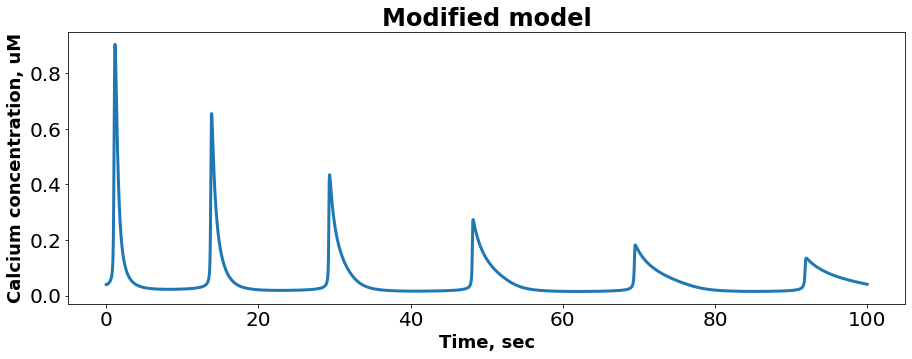

In [23]:
DSargs.ics      = {'x100': 0.8, 'x110': 0., 'Ca': 0.04, 'CaE': 200 }
DSargs.tdomain = [0,100]                         # the range of integration
ode  = dst.Generator.Vode_ODEsystem(DSargs)     # an instance of the 'Generator' class
traj = ode.compute('something')              # integrate ODE
pts  = traj.sample(dt=0.01)                      # Data for plotting

fig = plt.figure(figsize=(15,5))

plt.plot(pts['t'], pts['Ca'],linewidth = 3)
plt.xlabel(u'Time, sec',fontsize=18, fontweight = 'bold')                              
plt.ylabel(u'Calcium concentration, uM',fontsize=18, fontweight = 'bold')   
plt.tick_params(labelsize = 20)
plt.title('Modified model',fontsize=24, fontweight = 'bold')
#plt.show()
# plt.savefig('5a.tiff', dpi = 300)

In [97]:
pts['Ca'][-1]

0.002694050333500663

In [28]:
# Here we just pass IP3 concentration as a function argument
def simpleExample(IP3):
   
    DSargs.ics      = {'x100': 0.8, 'x110': 0., 'Ca': 0.04, 'CaE': 200 }
    DSargs.tdomain = [0,100]
    ode  = dst.Generator.Vode_ODEsystem(DSargs)   
#     And set it there
    ode.set(pars = {'p': IP3})
    traj = ode.compute('something')             
    pts  = traj.sample(dt=0.05)                     

    fig = plt.figure(figsize=(15,5))

    plt.plot(pts['t'], pts['Ca'],linewidth = 3)
    plt.xlabel(u'Time, sec',fontsize=18, fontweight = 'bold')                              
    plt.ylabel(u'Calcium concentration, uM',fontsize=18, fontweight = 'bold')   
    plt.tick_params(labelsize = 20)
    plt.title('Modified model',fontsize=24, fontweight = 'bold')

In [29]:
# Creating FloatSlider:
interact_manual(simpleExample, IP3=widgets.FloatSlider(description = 'IP3', value = .35, min = 0., max = 2.))

interactive(children=(FloatSlider(value=0.35, description='IP3', max=2.0), Button(description='Run Interact', …

<function __main__.simpleExample(IP3)>

In [122]:
# Here we pass a dictionary with all parameters as a function input
def f(**kwargs):
   
    DSargs.ics      = {'x100': 0.8, 'x110': 0., 'Ca': 0.04, 'CaE': 200 }
    DSargs.tdomain = [0,100]
    ode  = dst.Generator.Vode_ODEsystem(DSargs)     # an instance of the 'Generator' class
    
#     And use them there in a for loop
    for key in kwargs:
        ode.set(pars = {key: kwargs[key]})
    traj = ode.compute('something')              # integrate ODE
    pts  = traj.sample(dt=0.05)                      # Data for plotting

    fig = plt.figure(figsize=(15,5))

    plt.plot(pts['t'], pts['Ca'],linewidth = 3)
    plt.xlabel(u'Time, sec',fontsize=18, fontweight = 'bold')                              
    plt.ylabel(u'Calcium concentration, uM',fontsize=18, fontweight = 'bold')   
    plt.tick_params(labelsize = 20)
    plt.title('Modified model',fontsize=24, fontweight = 'bold')
    
# Then, we make a tuple of FloatSliders for each of parameters
sliders = tuple(widgets.FloatSlider(value = myPars[k], min = 0., max = myPars[k]*10.) for k in myPars.keys())
# And we make a dictionary with parameter name keys and sliders to map each of the sliders to model variables later
arg_dict = dict(zip(myStrings.keys(),sliders))
# Here we make user interface as a horisontal box of two vertical boxes
# With the left one containing labels and the right one containing sliders
ui = HBox([VBox(list(map(lambda x: Label(x),myStrings.values()))),VBox(children = sliders)])
# Passing dictionary of values to a function
out = widgets.interactive_output(f, arg_dict)
# Putting everything together
display(ui, out, continuous_update=False)

Output()